# Evaluate Models on Puzzles

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Xmaster6y/lczerolens/blob/main/docs/source/notebooks/features/evaluate-models-on-puzzles.ipynb)

## Setup

In [1]:
DEV = True

In [2]:
if DEV:
    !rm -r lczerolens
    !git clone https://github.com/Xmaster6y/lczerolens -b notebooks
    !pip install -q ./lczerolens
else:
    !pip install -q lczerolens

rm: cannot remove 'lczerolens': No such file or directory
Cloning into 'lczerolens'...
remote: Enumerating objects: 901, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 901 (delta 244), reused 224 (delta 166), pack-reused 483
Receiving objects: 100% (901/901), 995.47 KiB | 4.42 MiB/s, done.
Resolving deltas: 100% (444/444), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.

In [3]:
!gdown 1cxC8_8vw7akfPyc9cZxwaAbLG2Zl4XiT -O lc0-10-4238.onnx
!gdown 1TI429e9mr2de7LjHp2IIl7ouMoUaDjjZ -O leela-network.onnx

Downloading...
From: https://drive.google.com/uc?id=1cxC8_8vw7akfPyc9cZxwaAbLG2Zl4XiT
To: /content/lc0-10-4238.onnx
100% 15.2M/15.2M [00:00<00:00, 48.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TI429e9mr2de7LjHp2IIl7ouMoUaDjjZ
To: /content/leela-network.onnx
100% 3.48M/3.48M [00:00<00:00, 133MB/s]


## Load a Model

Load a leela network from file (already converted to `onnx`):

In [4]:
from lczerolens import LczeroModel

strong_model = LczeroModel.from_path(
    "lc0-10-4238.onnx"
)
weak_model = LczeroModel.from_path(
    "leela-network.onnx"
)

## Import a Puzzle Dataset

In [5]:
from datasets import load_dataset

dataset = load_dataset("lczerolens/lichess-puzzles", split="train")
dataset

Generating train split:   0%|          | 0/3974488 [00:00<?, ? examples/s]

Dataset({
    features: ['PuzzleId', 'FEN', 'Moves', 'Rating', 'RatingDeviation', 'Popularity', 'NbPlays', 'Themes', 'GameUrl', 'OpeningTags'],
    num_rows: 3974488
})

In [6]:
dataset.select_columns(["Rating","RatingDeviation"])[:10]

{'Rating': [1913, 1429, 1419, 1112, 1556, 1311, 1428, 1590, 1501, 1941],
 'RatingDeviation': [75, 73, 75, 74, 81, 75, 79, 75, 75, 85]}

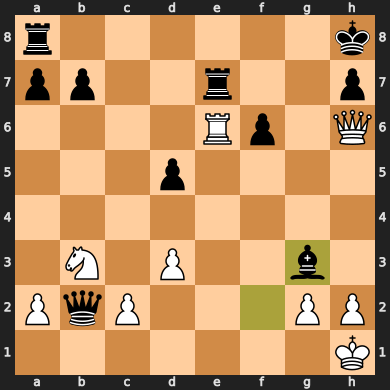

In [7]:
from lczerolens.play import Puzzle

puzzle = Puzzle.from_dict(dataset[0])
puzzle

## Define a Sampler

In [8]:
from lczerolens.play import PolicySampler, RandomSampler

strong_sampler = PolicySampler(use_argmax=True, model=strong_model)
weak_sampler = PolicySampler(use_argmax=True, model=weak_model)
random_sampler = RandomSampler()

s_res = puzzle.evaluate(strong_sampler)
w_res = puzzle.evaluate(weak_sampler)
r_res = puzzle.evaluate(random_sampler)
f"Strong: {s_res}, Weak: {w_res}, Random: {r_res}"

"Strong: {'score': 1.0, 'perplexity': 1.425853916318232}, Weak: {'score': 0.0, 'perplexity': 2.6202037960371665}, Random: {'score': 0.0, 'perplexity': 38.99999949149788}"

In [9]:
def puzzle_generator(dataset, lim=1_000):
    i = 0
    for d in dataset:
        i += 1
        if i > lim:
            break
        yield Puzzle.from_dict(d)

In [10]:
res_gen = Puzzle.evaluate_multiple(puzzle_generator(dataset), strong_sampler, use_perplexity=True, batch_size=1_000)

In [11]:
res_list = list(res_gen)
res_list[0]

{'score': 1.0, 'perplexity': 1.4258534315992657}

## Plot the Results

In [12]:
success_puzzles = []
fail_puzzles = []
success_perplexity = []
fail_perplexity = []
for m, puzzle in zip(res_list, puzzle_generator(dataset)):
    if m["score"] == 0:
        fail_puzzles.append(puzzle)
        fail_perplexity.append(m["perplexity"])
    else:
        success_puzzles.append(puzzle)
        success_perplexity.append(m["perplexity"])

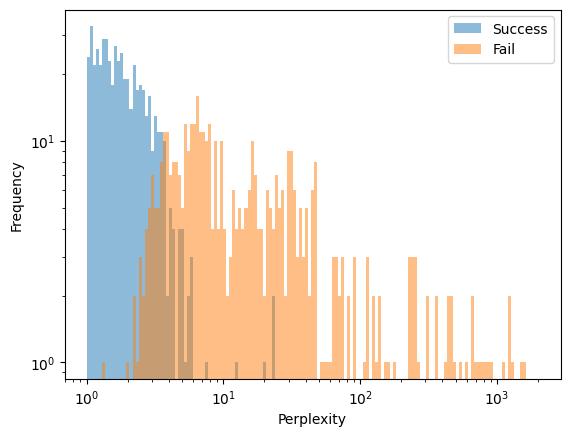

In [13]:
import matplotlib.pyplot as plt
import numpy as np

_, bins = np.histogram(success_perplexity + fail_perplexity)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), 150)

plt.hist(success_perplexity, bins=logbins, label="Success", alpha=0.5)
plt.hist(fail_perplexity, bins=logbins, label="Fail", alpha=0.5)
plt.xlabel("Perplexity")
plt.ylabel("Frequency")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [14]:
success_ratings = []
fail_ratings = []
for (s,_), puzzle in zip(res_list, puzzle_generator(dataset)):
    if s == 0:
        fail_ratings.append(puzzle.rating)
    else:
        success_ratings.append(puzzle.rating)

In [15]:
def plot_attribute(attribute, success_puzzles, fail_puzzles, bins=150, log=False, get_fn=None):
    get_fn = get_fn or (lambda puzzle: getattr(puzzle, attribute))
    success_values = [get_fn(puzzle) for puzzle in success_puzzles]
    fail_values = [get_fn(puzzle) for puzzle in fail_puzzles]

    if log:
        _, bins = np.histogram(success_values + fail_values)
        bins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), bins)

    plt.hist(success_values, bins=bins, label="Success", alpha=0.5)
    plt.hist(fail_values, bins=bins, label="Fail", alpha=0.5)
    plt.xlabel(attribute)
    plt.ylabel("Frequency")
    if log:
        plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.show()

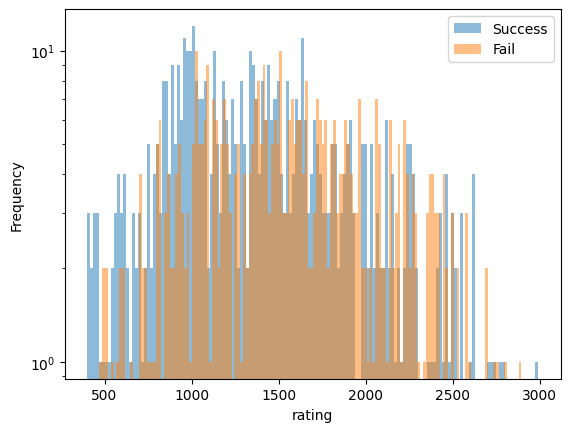

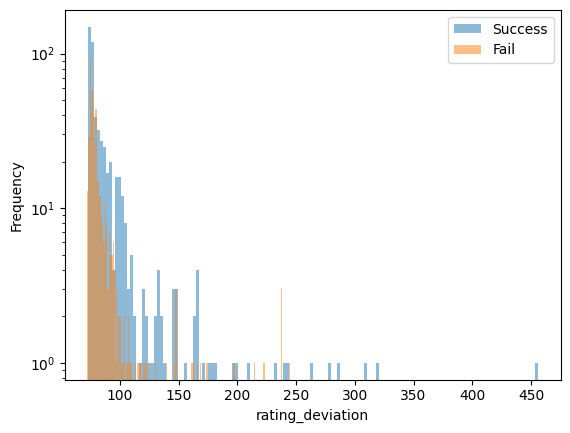

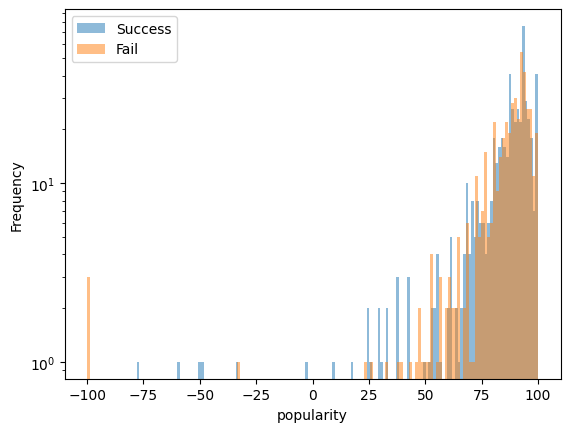

In [16]:
plot_attribute("rating", success_puzzles, fail_puzzles)
plot_attribute("rating_deviation", success_puzzles, fail_puzzles)
plot_attribute("popularity", success_puzzles, fail_puzzles)